
# **Exploring neural data with PCA**
#### This notebook provides an exploratory analysis of neuroscience data, specifically using principal component analysis (PCA) and feature-based aggregation. The dataset of light-sheet imaging was recorded by the [Ahrens Lab](http://www.janelia.org/lab/ahrens-lab) at Janelia Research Campus, and hosted on the CodeNeuro [data repository](http://datasets.codeneuro.org).
#### The dataset is generated by the brain of a transparent larval zebrafish. The activity over its entire brain can be recorded using a technique called light-sheet microscopy.   This dataset consists of time-varying images containing patterns of the zebrafish's neural activity as it is presented with a moving visual pattern.   Different stimuli induce different patterns across the brain, and we can use exploratory analyses to identify these patterns. We can use different decoders to try to predict what visual stimulus the fish is looking at based on its neural activity, finding the upper limit on the informational content of neural activity. 

 
### **Part 1: Work through the steps of PCA**

#### **(1a) Covariance Function**
#### A function to compute the sample covariance matrix for an arbitrary `data` RDD.

In [1]:
 
def estimateCovariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    meanData = data.mean()
    zeroMeanData = data.map(lambda x: x-meanData)
    return zeroMeanData.map(lambda x: np.outer(x,x)).sum()/zeroMeanData.count()



#### **(1b) Eigendecomposition**
#### After we have computed the sample covariance matrix, we can use it to find directions of maximal variance in the data.  We perform an eigendecomposition of this matrix to find its eigenvalues and eigenvectors.  The $\scriptsize d $ eigenvectors of the covariance matrix give us the directions of maximal variance, or the "principal components."  The associated eigenvalues are the variances in these directions.   
 
#### We use a function from `numpy.linalg` called eigh to perform the eigendecomposition.  Next, sort the eigenvectors based on their corresponding eigenvalues (from high to low), yielding a matrix where the columns are the eigenvectors (and the first column is the top eigenvector).  Finally, set the `topComponent` variable equal to the top eigenvector or prinicipal component, which is a $\scriptsize 2 $-dimensional vector (array with two values).

In [2]:
from numpy.linalg import eigh

### **Part 2: Write a PCA function**

#### **(2a) PCA function**
#### A general PCA function will compute the top $\scriptsize k$ principal components and principal scores for a given dataset.  

In [3]:
 
def pca(data, k):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """

    covarianceData = estimateCovariance(data)
    eigVals, eigVecs = eigh(covarianceData)
    inds = np.argsort(eigVals)
    cols = k
    maxIndex = max(inds)
    topComponent = eigVecs[:,inds[-1]]
    topKCols = inds[::-1][:k]
    correlatedDataScores = data.map(lambda x: x.dot(eigVecs[:,topKCols]))
    # Return the `k` principal components, `k` scores, and all eigenvalues]
    return (eigVecs[:,topKCols], correlatedDataScores, eigVals[inds[::-1]])
    


#### **(2d) Variance explained**
#### The following function computes the fraction of retained variance by the top principal components.  If the initial data is $\scriptsize d$-dimensional, then the total variance in our data equals: $ \scriptsize \sum_{i=1}^d \lambda_i $, where $\scriptsize \lambda_i$ is the eigenvalue corresponding to the $\scriptsize i$th principal component. If we use PCA with some $\scriptsize k < d$, then we can compute the variance retained by these principal components by adding the top $\scriptsize k$ eigenvalues.  The fraction of retained variance equals the sum of the top $\scriptsize k$ eigenvalues divided by the sum of all of the eigenvalues.

In [4]:
 
def varianceExplained(data, k=1):
    """Calculate the fraction of variance explained by the top `k` eigenvectors.

    Args:
        data (RDD of np.ndarray): An RDD that contains NumPy arrays which store the
            features for an observation.
        k: The number of principal components to consider.

    Returns:
        float: A number between 0 and 1 representing the percentage of variance explained
            by the top `k` eigenvectors.
    """
    components, scores, eigenvalues = pca(data, k )
    return sum(eigenvalues[:k])/sum(eigenvalues)


 
### **Part 3:  Parse, inspect, and preprocess neuroscience data then perform PCA **

 
#### **Data introduction**
#### A central challenge in neuroscience is understanding the organization and function of neurons, the cells responsible for processing and representing information in the brain. New technologies make it possible to monitor the responses of large populations of neurons in awake animals. The genetically modified zebrafish is engineered so that its neurons express special proteins that flouresce or light up when active, and then use microscopy to record neural activity as images. Light-sheet microscopy allows monitoring neural activity over nearly its entire brain. The resulting data are time-varying images containing the activity of hundreds of thousands of neurons. Given the enormous data, we want to find compact spatial and temporal patterns: Which groups of neurons are active together? What is the time course of their activity? We next use PCA to address these questions. 

#### **(3a) Load neuroscience data**
####The raw data are currently stored as a text file. Every line in the file contains the time series of image intensity for a single pixel in a time-varying image (i.e. a movie). The first two numbers in each line are the spatial coordinates of the pixel, and the remaining numbers are the time series. We'll use first() to inspect a single row, and print just the first 100 characters.

In [32]:
import os
baseDir = os.path.join('data')
inputPath = os.path.join('cs190', 'neuro.txt')

inputFile = os.path.join(baseDir, inputPath)

lines = sc.textFile(inputFile)
print lines.first()[0:100]

# Check that everything loaded properly
assert len(lines.first()) == 1397
assert lines.count() == 46460

0 0 103 103.7 103.2 102.7 103.8 102.8 103 103.3 103.8 103.2 102.1 103.5 103.2 102.7 103.1 102.2 102.


#### **(3b) Parse the data**
#### Parse the data into a key-value representation. We want each key to be a tuple of two-dimensional spatial coordinates and each value to be a NumPy array storing the associated time series. Write a function that converts a line of text into a (`tuple`, `np.ndarray`) pair. Then apply this function to each record in the RDD, and inspect the first entry of the new parsed data set. We then cache the data, and force a computation by calling count, to ensure the data are cached.

In [33]:
 
def parse(line):
    """Parse the raw data into a (`tuple`, `np.ndarray`) pair.

    Note:
        You should store the pixel coordinates as a tuple of two ints and the elements of the pixel intensity
        time series as an np.ndarray of floats.

    Args:
        line (str): A string representing an observation.  Elements are separated by spaces.  The
            first two elements represent the coordinates of the pixel, and the rest of the elements
            represent the pixel intensity over time.

    Returns:
        tuple of tuple, np.ndarray: A (coordinate, pixel intensity array) `tuple` where coordinate is
            a `tuple` containing two values and the pixel intensity is stored in an NumPy array
            which contains 240 values.
    """
    data = line.split()
    return ((int(data[0]), int(data[1])), (np.array(data[2:])).astype(np.float))

rawData = lines.map(parse)
rawData.cache()
entry = rawData.first()

print 'Length of movie is {0} seconds'.format(len(entry[1]))
print 'Number of pixels in movie is {0:,}'.format(rawData.count())
print ('\nFirst entry of rawData (with only the first five values of the NumPy array):\n({0}, {1})'
       .format(entry[0], entry[1][:5]))

Length of movie is 240 seconds
Number of pixels in movie is 46,460

First entry of rawData (with only the first five values of the NumPy array):
((0, 0), [ 103.   103.7  103.2  102.7  103.8])


#### **(3c) Min and max flouresence**
#### Next we'll do some basic preprocessing on the data. The raw time-series data are in units of image flouresence, and baseline flouresence varies somewhat arbitrarily from pixel to pixel. First, compute the minimum and maximum values across all pixels.

In [36]:
 
mx = rawData.map(lambda x: max(x[1])).takeOrdered(1, key= lambda x: -x)
mn = rawData.map(lambda x: min(x[1])).takeOrdered(1, key= lambda x:  x)

print mn, mx

[100.59999999999999] [940.79999999999995]


#### **Visualization 5: Pixel intensity**
#### Next we look at how a random pixel varies in value over the course of the time series. 

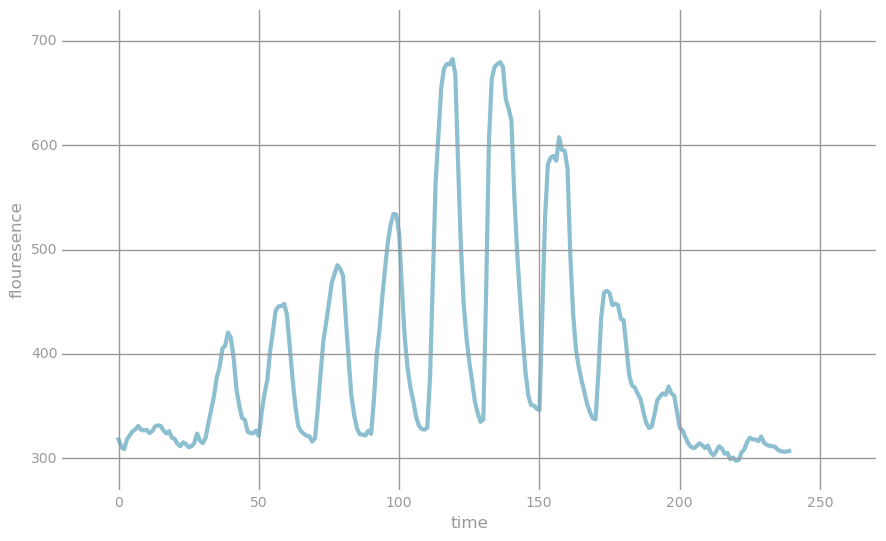

In [38]:
example = rawData.filter(lambda (k, v): np.std(v) > 100).values().first()

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 300, 50), np.arange(300, 800, 100))
ax.set_xlabel(r'time'), ax.set_ylabel(r'flouresence')
ax.set_xlim(-20, 270), ax.set_ylim(270, 730)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
pass

#### **(3d) Fractional signal change**
####To convert from these raw flouresence units to more intuitive units of fractional signal change, a function takes a time series for a particular pixel and subtracts and divides by the mean.  

In [39]:
 
def rescale(ts):
    """Take a np.ndarray and return the standardized array by subtracting and dividing by the mean.

    Note:
        You should first subtract the mean and then divide by the mean.

    Args:
        ts (np.ndarray): Time series data (`np.float`) representing pixel intensity.

    Returns:
        np.ndarray: The times series adjusted by subtracting the mean and dividing by the mean.
    """
    mean = sum(ts) / float(len(ts))
    return np.asarray([(i-mean)/mean for i in ts])

scaledData = rawData.mapValues(lambda v: rescale(v))
mnScaled = scaledData.map(lambda (k, v): v).map(lambda v: min(v)).min()
mxScaled = scaledData.map(lambda (k, v): v).map(lambda v: max(v)).max()
print mnScaled, mxScaled

-0.271512880125 0.905448764348


#### **Visualization 6: Normalized data**
#### We now visualize the normalize data pixel intensity. 

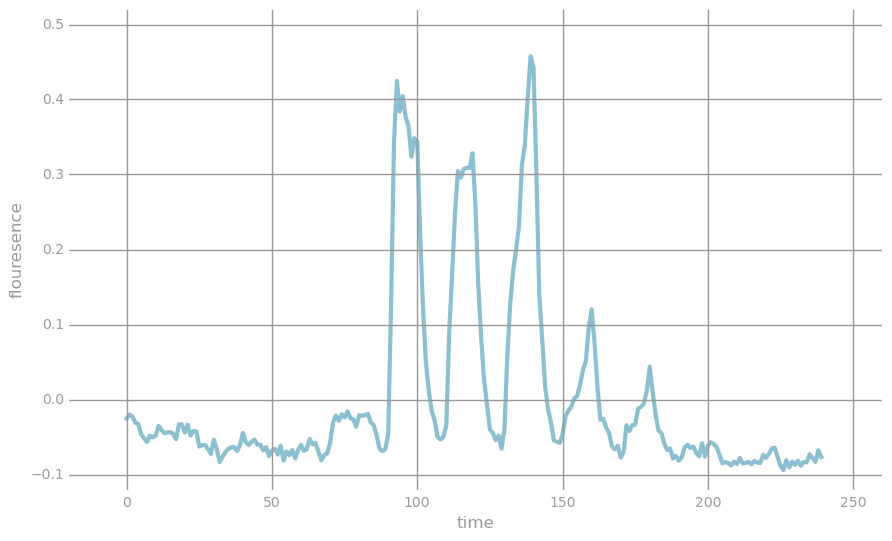

In [42]:
example = scaledData.filter(lambda (k, v): np.std(v) > 0.1).values().first()

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 300, 50), np.arange(-.1, .6, .1))
ax.set_xlabel(r'time'), ax.set_ylabel(r'flouresence')
ax.set_xlim(-20, 260), ax.set_ylim(-.12, .52)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
pass

#### **(3e) PCA on the scaled data**
#### We now have a preprocessed dataset with $\scriptsize n = 46460$ pixels and $\scriptsize d = 240$ seconds of time series data for each pixel.  We can interpret the pixels as our observations and each pixel value in the time series as a feature.  We would like to find patterns in brain activity during this time series, and we expect to find correlations over time.  We can use PCA to find a more compact representation of our data and allow us to visualize it.
 
#### We now use the `pca` function to perform PCA on the preprocessed neuroscience data with $\scriptsize k = 3$, resulting in a new low-dimensional 46460 by 3 dataset.  

In [47]:
 
# Run pca using scaledData
componentsScaled, scaledScores, eigenvaluesScaled = pca(scaledData.values(), 3)

#### **Visualization 7: Top two components as images**
#### Now, we'll view the scores for the top two component as images.  Note that we reshape the vectors by the dimensions of the original image, 230 x 202.
#### These graphs map the values for the single component to a grayscale image.  This provides us with a visual representation which we can use to see the overall structure of the zebrafish brain and to identify where high and low values occur.  

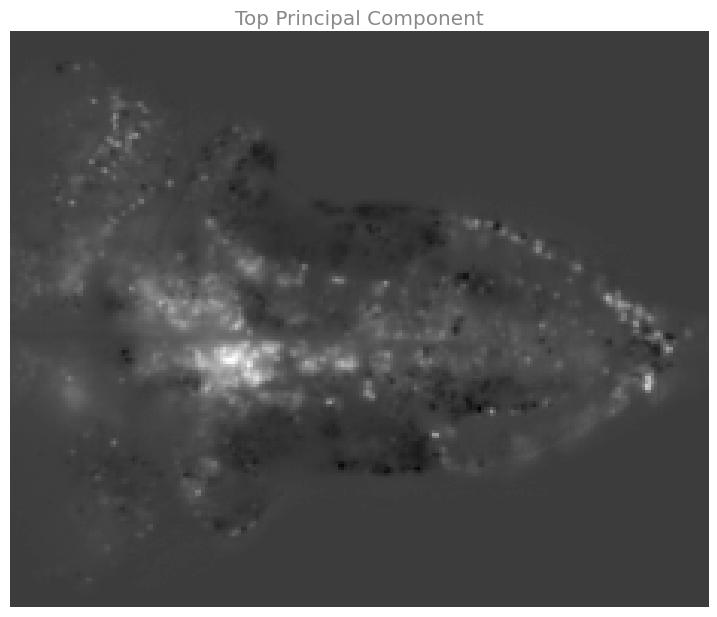

In [49]:
import matplotlib.cm as cm

scoresScaled = np.vstack(scaledScores.collect())
imageOneScaled = scoresScaled[:,0].reshape(230, 202).T

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
ax.set_title('Top Principal Component', color='#888888')
image = plt.imshow(imageOneScaled,interpolation='nearest', aspect='auto', cmap=cm.gray)
pass

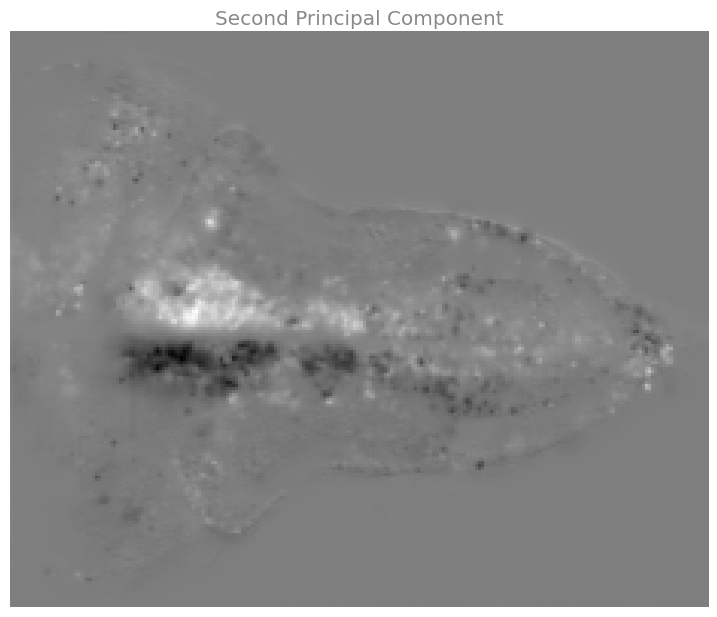

In [50]:
imageTwoScaled = scoresScaled[:,1].reshape(230, 202).T

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
ax.set_title('Second Principal Component', color='#888888')
image = plt.imshow(imageTwoScaled,interpolation='nearest', aspect='auto', cmap=cm.gray)
pass

#### **Visualization 8: Top two components as one image**
#### When we perform PCA and color neurons based on their location in the low-dimensional space, we can interpret areas with similar colors as exhibiting similar responses (at least in terms of the simple representation we recover with PCA). The graph shows the result of this color mapping using the zebrafish neural data.
 
####It clearly exhibits patterns of neural similarity throughout different regions of the brain.  However, when performing PCA on the full dataset, there are multiple reasons why neurons might have similar responses. The neurons might respond similarly to different stimulus directions, their responses might have  similar temporal dynamics, or their response similarity could be influenced by both temporal and stimulus-specific factors. In this initial PCA analysis, we cannot pin down the underlying factors, and hence it is hard to interpret what "similarity" really means.

In [51]:
# Adapted from python-thunder's Colorize.transform where cmap='polar'.
# Checkout the library at: https://github.com/thunder-project/thunder and
# http://thunder-project.org/

def polarTransform(scale, img):
    """Convert points from cartesian to polar coordinates and map to colors."""
    from matplotlib.colors import hsv_to_rgb

    img = np.asarray(img)
    dims = img.shape

    phi = ((np.arctan2(-img[0], -img[1]) + np.pi/2) % (np.pi*2)) / (2 * np.pi)
    rho = np.sqrt(img[0]**2 + img[1]**2)
    saturation = np.ones((dims[1], dims[2]))

    out = hsv_to_rgb(np.dstack((phi, saturation, scale * rho)))

    return np.clip(out * scale, 0, 1)

In [ ]:
# Show the polar mapping from principal component coordinates to colors.
x1AbsMax = np.max(np.abs(imageOneScaled))
x2AbsMax = np.max(np.abs(imageTwoScaled))

numOfPixels = 300
x1Vals = np.arange(-x1AbsMax, x1AbsMax, (2 * x1AbsMax) / numOfPixels)
x2Vals = np.arange(x2AbsMax, -x2AbsMax, -(2 * x2AbsMax) / numOfPixels)
x2Vals.shape = (numOfPixels, 1)

x1Data = np.tile(x1Vals, (numOfPixels, 1))
x2Data = np.tile(x2Vals, (1, numOfPixels))

# Try changing the first parameter to lower values
polarMap = polarTransform(2.0, [x1Data, x2Data])

gridRange = np.arange(0, numOfPixels + 25, 25)
fig, ax = preparePlot(gridRange, gridRange, figsize=(9.0, 7.2), hideLabels=True)
image = plt.imshow(polarMap, interpolation='nearest', aspect='auto')
ax.set_xlabel('Principal component one'), ax.set_ylabel('Principal component two')
gridMarks = (2 * gridRange / float(numOfPixels) - 1.0)
x1Marks = x1AbsMax * gridMarks
x2Marks = -x2AbsMax * gridMarks
ax.get_xaxis().set_ticklabels(map(lambda x: '{0:.1f}'.format(x), x1Marks))
ax.get_yaxis().set_ticklabels(map(lambda x: '{0:.1f}'.format(x), x2Marks))
pass

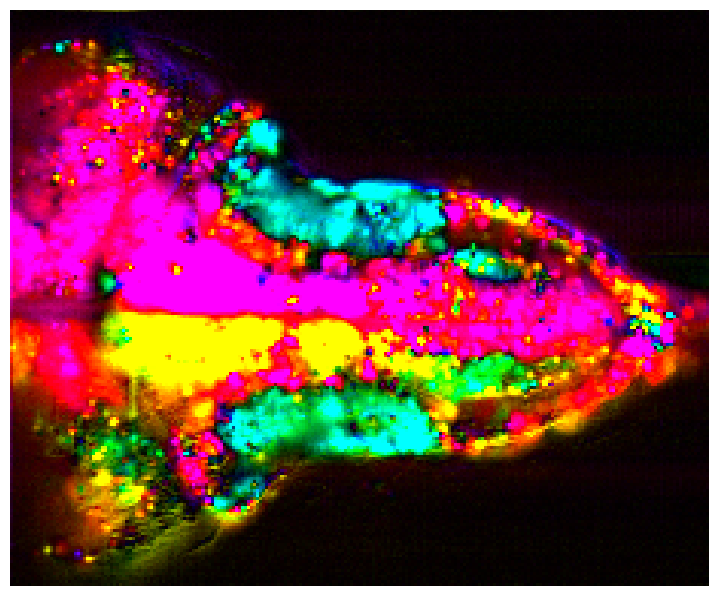

In [52]:
# Use the same transformation on the image data
# Try changing the first parameter to lower values
brainmap = polarTransform(2.0, [imageOneScaled, imageTwoScaled])

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
image = plt.imshow(brainmap,interpolation='nearest', aspect='auto')
pass

### **Part 4: Feature-based aggregation and PCA**

#### We performed PCA on the full time series data, trying to find global patterns across all 240 seconds of the time series. However, our analysis doesn't use the fact that different events happened during those 240 seconds. Specifically, during those 240 seconds, the zebrafish was presented with 12 different direction-specific visual patterns, with each one lasting for 20 seconds, for a total of 12 x 20 = 240 features.

#### **(4a) Aggregate by time** We now study the temporal aspects of neural response, by aggregating our features by time. We want to see how different pixels (and the underlying neurons captured in these pixels) react in each of the 20 seconds after a new visual pattern is displayed, regardless of what the pattern is.  Hence, instead of working with the 240 features individually, we'll aggregate the original features into 20 new features, where the first new feature captures the pixel response one second after a visual pattern appears, the second new feature is the response after two seconds, and so on.
 
#### We perform this aggregation using a map operation. First, we build a multi-dimensional array $ \scriptsize \mathbf{T} $ that, when dotted with a 240-dimensional vector, sums every 20-th component of this vector and returns a 20-dimensional vector.  

In [68]:
 
# Create a multi-dimensional array to perform the aggregation
T = np.tile(np.eye(20),12)  

# Transform scaledData using T.  Make sure to retain the keys.
timeData = scaledData.mapValues(lambda x: T.dot(x))

timeData.cache()
print timeData.count()
print timeData.first()

46460
((0, 0), array([ 0.00802155,  0.00607693, -0.0075354 ,  0.00121539,  0.02163388,
        0.00121539, -0.03087082,  0.00510462,  0.01191079,  0.02455081,
       -0.0182308 ,  0.00802155, -0.00948002, -0.00948002,  0.02163388,
       -0.02212004,  0.00704924,  0.00121539, -0.01142464, -0.00850771]))


#### ** Obtain a compact representation**
#### We now have a time-aggregated dataset with $\scriptsize n = 46460$ pixels and $\scriptsize d = 20$ aggregated time features, and we want to use PCA to find a more compact representation.   

In [70]:
 
componentsTime, timeScores, eigenvaluesTime = pca(timeData.values(),3)
print 'componentsTime: (first five) \n{0}'.format(componentsTime[:5,:])
print ('\ntimeScores (first three): \n{0}'
       .format('\n'.join(map(str, timeScores.take(3)))))
print '\neigenvaluesTime: (first five) \n{0}'.format(eigenvaluesTime[:5])

componentsTime: (first five) 
[[ 0.27392702 -0.16152431  0.01388556]
 [ 0.09941893 -0.31968127 -0.34738824]
 [-0.03376505 -0.32933108 -0.35606954]
 [-0.12092744 -0.2845482  -0.27232364]
 [-0.18219248 -0.22998061 -0.12248985]]

timeScores (first three): 
[-0.00720617 -0.00292979 -0.00223645]
[ 0.02353076 -0.00197457  0.00362094]
[ 0.01310623  0.00123069 -0.00582974]

eigenvaluesTime: (first five) 
[ 0.77528991  0.05038881  0.01173423  0.0059711   0.00138073]


#### ** Visualization 9: Top two components by time **
#### Let's view the scores from the first two PCs as a composite image. When we preprocess by aggregating by time and then perform PCA, we are only looking at variability related to temporal dynamics. As a result, if neurons appear similar -- have similar colors -- in the resulting image, it means that their responses vary similarly over time, regardless of how they might be encoding direction. In the image below, we can define the midline as the horizontal line across the middle of the brain.  We see clear patterns of neural activity in different parts of the brain, and crucially note that the regions on either side of the midline are similar, which suggests that temporal dynamics do not differ across the two sides of the brain.

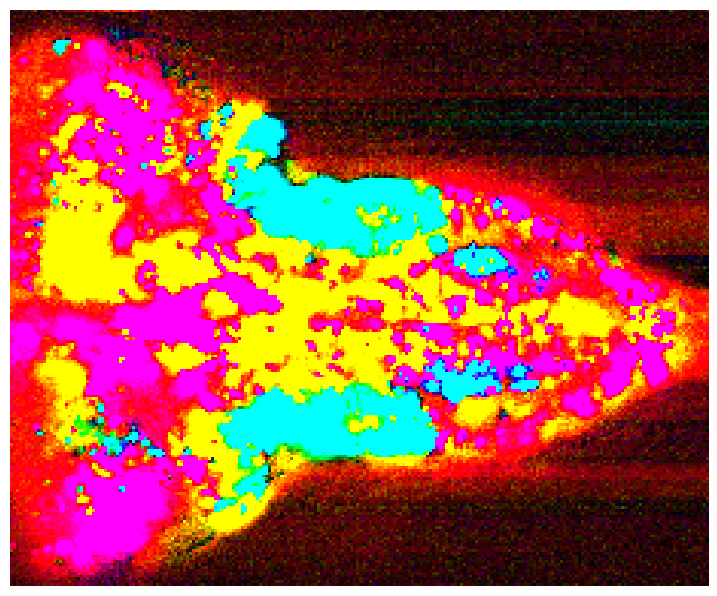

In [72]:
scoresTime = np.vstack(timeScores.collect())
imageOneTime = scoresTime[:,0].reshape(230, 202).T
imageTwoTime = scoresTime[:,1].reshape(230, 202).T
brainmap = polarTransform(3, [imageOneTime, imageTwoTime])

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
image = plt.imshow(brainmap,interpolation='nearest', aspect='auto')
pass

#### **(4b) Aggregate by direction**
#### We next perform a second type of feature aggregation so that we can study the direction-specific aspects of neural response, by aggregating our features by direction. In other words, we want to see how different pixels (and the underlying neurons captured in these pixels) react when the zebrafish is presented with 12 direction-specific patterns, ignoring the temporal aspect of the reaction.  Hence, instead of working with the 240 features individually, we'll aggregate the original features into 12 new features, where the first new feature captures the average pixel response to the first direction-specific visual pattern, the second new feature is the response to the second direction-specific visual pattern, and so on.
  

In [76]:
 
# Create a multi-dimensional array to perform the aggregation
D =  np.kron(np.eye(12),np.ones(20))

# Transform scaledData using D.  Make sure to retain the keys.
directionData = scaledData.mapValues(lambda x: D.dot(x))

directionData.cache()
print directionData.count()
print directionData.first()

46460
((0, 0), array([ 0.03346365,  0.03638058, -0.02195799, -0.02487492,  0.00721129,
        0.00332206, -0.02098568,  0.00915591, -0.00542873, -0.01029027,
        0.0081836 , -0.01417951]))


#### **(4g) Compact representation of direction data**
#### We now have a direction-aggregated dataset with $\scriptsize n = 46460$ pixels and $\scriptsize d = 12$ aggregated direction features, and we want to use PCA to find a more compact representation.  Use the `pca` function from Part (2a) to perform PCA on the this data with $\scriptsize k = 3$, resulting in a new low-dimensional 46460 by 3 dataset. As before, you'll need to extract the values from `directionData` since it is an RDD of key-value pairs.

In [79]:
 
componentsDirection, directionScores, eigenvaluesDirection = pca(directionData.values(),3)

print 'componentsDirection: (first five) \n{0}'.format(componentsDirection[:5,:])
print ('\ndirectionScores (first three): \n{0}'
       .format('\n'.join(map(str, directionScores.take(3)))))
print '\neigenvaluesDirection: (first five) \n{0}'.format(eigenvaluesDirection[:5])

componentsDirection: (first five) 
[[-0.25952179  0.16201941  0.24947433]
 [-0.31369506 -0.09185175  0.29464223]
 [-0.21716693 -0.35944645  0.35296454]
 [-0.11517273 -0.37356905  0.07169062]
 [ 0.02996577 -0.36272623 -0.14783897]]

directionScores (first three): 
[-0.01622513  0.01322998  0.01322204]
[ 0.00999482  0.0652367  -0.04524758]
[ 0.004646    0.05751097  0.00756383]

eigenvaluesDirection: (first five) 
[ 0.96411048  0.77613553  0.12762987  0.09775924  0.04333691]


 
#### **Visualization 10: Top two components by direction**
#### Again, let's view the scores from the first two PCs as a composite image.  When we preprocess by averaging across time (group by direction), and then perform PCA, we are only looking at variability related to stimulus direction. As a result, if neurons appear similar -- have similar colors -- in the image, it means that their responses vary similarly across directions, regardless of how they evolve over time. In the image below, we see a different pattern of similarity across regions of the brain.  Moreover, regions on either side of the midline are colored differently, which suggests that we are looking at a property, direction selectivity, that has a different representation across the two sides of the brain.

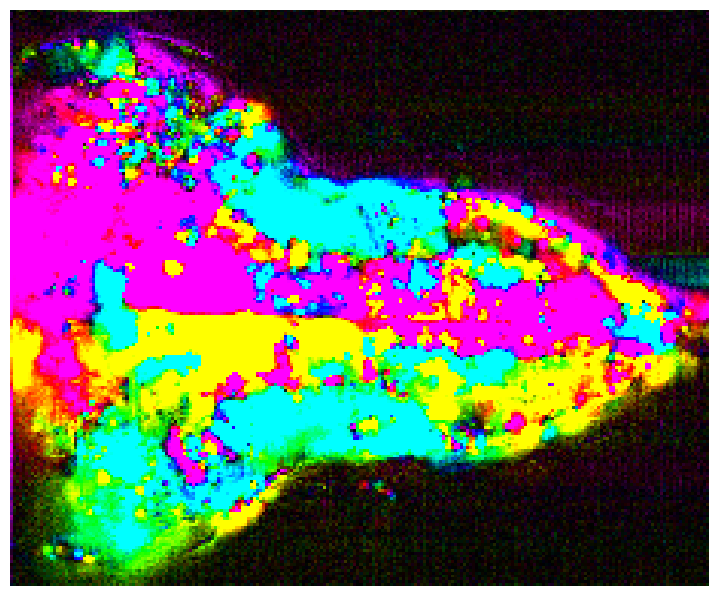

In [81]:
scoresDirection = np.vstack(directionScores.collect())
imageOneDirection = scoresDirection[:,0].reshape(230, 202).T
imageTwoDirection = scoresDirection[:,1].reshape(230, 202).T
brainmap = polarTransform(2, [imageOneDirection, imageTwoDirection])
# with thunder: Colorize(cmap='polar', scale=2).transform([imageOneDirection, imageTwoDirection])

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hideLabels=True)
ax.grid(False)
image = plt.imshow(brainmap, interpolation='nearest', aspect='auto')
pass